In [1]:
import sys
sys.path.insert(0, '..//src')

import global_func as gf
import load_data
import data_preprocessing as dp

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

config_dir = '..\\config\\'
data_raw_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_RAW')
data_proc_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_PROCESSED')
data_remod_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_REMODEL')

# Data Collection

In [ ]:
df_raw = load_data.load_csv(f"{data_raw_dir}{gf.read_config(config_dir=config_dir, section='FILENAME', key='DATASET')}.csv")
df_raw.head()

# Data Definition & Validation

In [ ]:
print(df_raw.info())
print()
print(df_raw.isna().sum())

## Resample data time-series: Interval = hari-kerja

In [ ]:
df_proc = dp.resampling(dataframe=df_raw, interval='B', resampling_method='median', fillna_method='ffill')
df_proc.tail()

## Set Target

In [ ]:
df_proc = dp.set_target(dataframe=df_proc, 
                        datacolumn=gf.read_config(config_dir=config_dir, section='FEATURES', key='TARGET_COL'), 
                        future_days=int(gf.read_config(config_dir=config_dir, section='FEATURES', key='TARGET_DAYS')))
df_proc.tail()

## Feature enriching

In [ ]:
df_proc = dp.enriching(dataframe=df_proc)
df_proc.tail()

# Data Splitting

In [ ]:
train_end = gf.read_config(config_dir=config_dir, section='FEATURES', key='TRAIN_END')
valid_end = gf.read_config(config_dir=config_dir, section='FEATURES', key='VALID_END')

df_train, df_valid, df_test = dp.splitting(dataframe=df_proc, train_end=train_end, valid_end=valid_end)
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'
'''
gf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_01.pkl', compress=5)
gf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_01.pkl', compress=5)
gf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_01.pkl', compress=5)
'''

# Target Overview

In [ ]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_01.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_01.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_01.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'


## Explorasi Target

In [ ]:
def plotting_target(train, valid, test):
    fig = plt.figure(figsize=(18,5))

    for frame in [train, valid, test]:
        plt.plot(frame.index, frame['target'], label=frame.name)

    plt.legend(loc='upper left')
    fig.tight_layout()
    plt.show()

plotting_target(df_train, df_valid, df_test)

## Explorasi Tren

In [ ]:
def plotting_tren(df):
    df_monthly = dp.resampling(dataframe=df, interval='M', resampling_method='median', fillna_method='ffill')
    df_quarterly = dp.resampling(dataframe=df, interval='Q', resampling_method='median', fillna_method='ffill')
    df_yearly = dp.resampling(dataframe=df, interval='A', resampling_method='median', fillna_method='ffill')
    
    df_monthly.name = 'monthly'
    df_quarterly.name = 'quarterly'
    df_yearly.name = 'yearly'

    fig = plt.figure(figsize=(18,5))
    for frame in [df, df_monthly, df_quarterly, df_yearly]:
        plt.plot(frame.index, frame['target'], label=frame.name)
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_tren(df=df_train)

# Dekomposisi Seasonal

In [ ]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_01.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_01.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_01.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

In [ ]:
result_mul, _ = dp.monthly_seasonal_feature(dataframe_train=df_train)

result_mul.seasonal[:24].to_frame().plot(subplots=True,figsize =(10,3))
plt.title('Seasonal trend (monthly)')
plt.show()

## Feature enriching: col seasonal

In [ ]:
fname = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='DF_SEASONAL') + '.pkl'
df_seasonal = gf.load_from_pkl(fname)
df_train = dp.enriching_seasonal(dataframe=df_train, df_seasonal=df_seasonal)
df_valid = dp.enriching_seasonal(dataframe=df_valid, df_seasonal=df_seasonal)
df_test = dp.enriching_seasonal(dataframe=df_test, df_seasonal=df_seasonal)

'''
gf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_02.pkl', compress=5)
gf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_02.pkl', compress=5)
gf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_02.pkl', compress=5)
'''

# Cek stasionary & Transform Lag-Differencing

In [ ]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_02.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_02.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_02.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

## Augmented Dickey-Fuller Test
The time series is considered stationary if the p-value is low (<0.05) and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

In [ ]:
non_stationary_cols = dp.stationary_checker_with_adfuller(dataframe=df_train, show_detail=True)
#non_stationary_cols_fname = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='NONSTATIONARY_COL_LIST') + '.pkl'
#gf.save_as_pkl(obj=non_stationary_cols, filename=non_stationary_cols_fname, compress=5)

In [ ]:
non_stationary_cols_pkl = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='NONSTATIONARY_COL_LIST') + '.pkl'

df_train = dp.stationary_transform(dataframe=df_train, non_stationary_cols_pkl=non_stationary_cols_pkl)
df_valid = dp.stationary_transform(dataframe=df_valid, non_stationary_cols_pkl=non_stationary_cols_pkl)
df_test = dp.stationary_transform(dataframe=df_test, non_stationary_cols_pkl=non_stationary_cols_pkl)
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

'''
gf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_03.pkl', compress=5)
gf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_03.pkl', compress=5)
gf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_03.pkl', compress=5)
'''

In [ ]:
def plotting_stasioner(train, valid, test, col):
    fig, axes = plt.subplots(figsize=[18, 5])

    for frame in [train, valid, test]:
        rol_mean = frame[col].rolling(window = 30, center = False).mean()
        rol_std = frame[col].rolling(window = 30, center = False).std()

        axes.plot(frame.index, frame[col], label=frame.name)
        axes.plot(rol_mean, label=f'{frame.name}: rolling mean', color='black')
        axes.plot(rol_std, label=f'{frame.name}: rolling std', color='maroon')

    axes.legend(loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

plotting_stasioner(df_train, df_valid, df_test ,col='target')

# Cek Outlier & Imputasi

In [ ]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_03.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_03.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_03.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

## Plotting: Histogram

In [ ]:
gf.plotting_hist_all(dataframe=df_train)

## Plotting: Boxplot

In [ ]:
gf.plotting_box_all(dataframe=df_train)

## Imputasi

In [ ]:
df_value_for_outlier = dp.get_value_for_outlier(train_dataframe=df_train, lo_perc=10.0, hi_perc=90.0)
df_train = dp.outlier_treatment_batch(dataframe=df_train, df_value_for_outlier=df_value_for_outlier)
df_valid = dp.outlier_treatment_batch(dataframe=df_valid, df_value_for_outlier=df_value_for_outlier)
df_test = dp.outlier_treatment_batch(dataframe=df_test, df_value_for_outlier=df_value_for_outlier)
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

'''
gf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_04.pkl', compress=5)
gf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_04.pkl', compress=5)
gf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_04.pkl', compress=5)
'''

# Standardizing

In [5]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_04.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_04.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_04.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

In [ ]:
gf.plotting_line_all(dataframe=df_train)

In [8]:
scaler = dp.std_scaler_fitting(train_dataframe=df_train)
df_train = dp.std_scaler_transform(dataframe=df_train, scaler=scaler)
df_valid = dp.std_scaler_transform(dataframe=df_valid, scaler=scaler)
df_test = dp.std_scaler_transform(dataframe=df_test, scaler=scaler)

'''
gf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_05_stdz.pkl', compress=5)
gf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_05_stdz.pkl', compress=5)
gf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_05_stdz.pkl', compress=5)
'''

"\ngf.save_as_pkl(obj=df_train, filename=f'{data_proc_dir}df_train_05_stdz.pkl', compress=5)\ngf.save_as_pkl(obj=df_valid, filename=f'{data_proc_dir}df_valid_05_stdz.pkl', compress=5)\ngf.save_as_pkl(obj=df_test, filename=f'{data_proc_dir}df_test_05_stdz.pkl', compress=5)\n"

# Final Dataframe for modelling

In [9]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_05_stdz.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_05_stdz.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_05_stdz.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

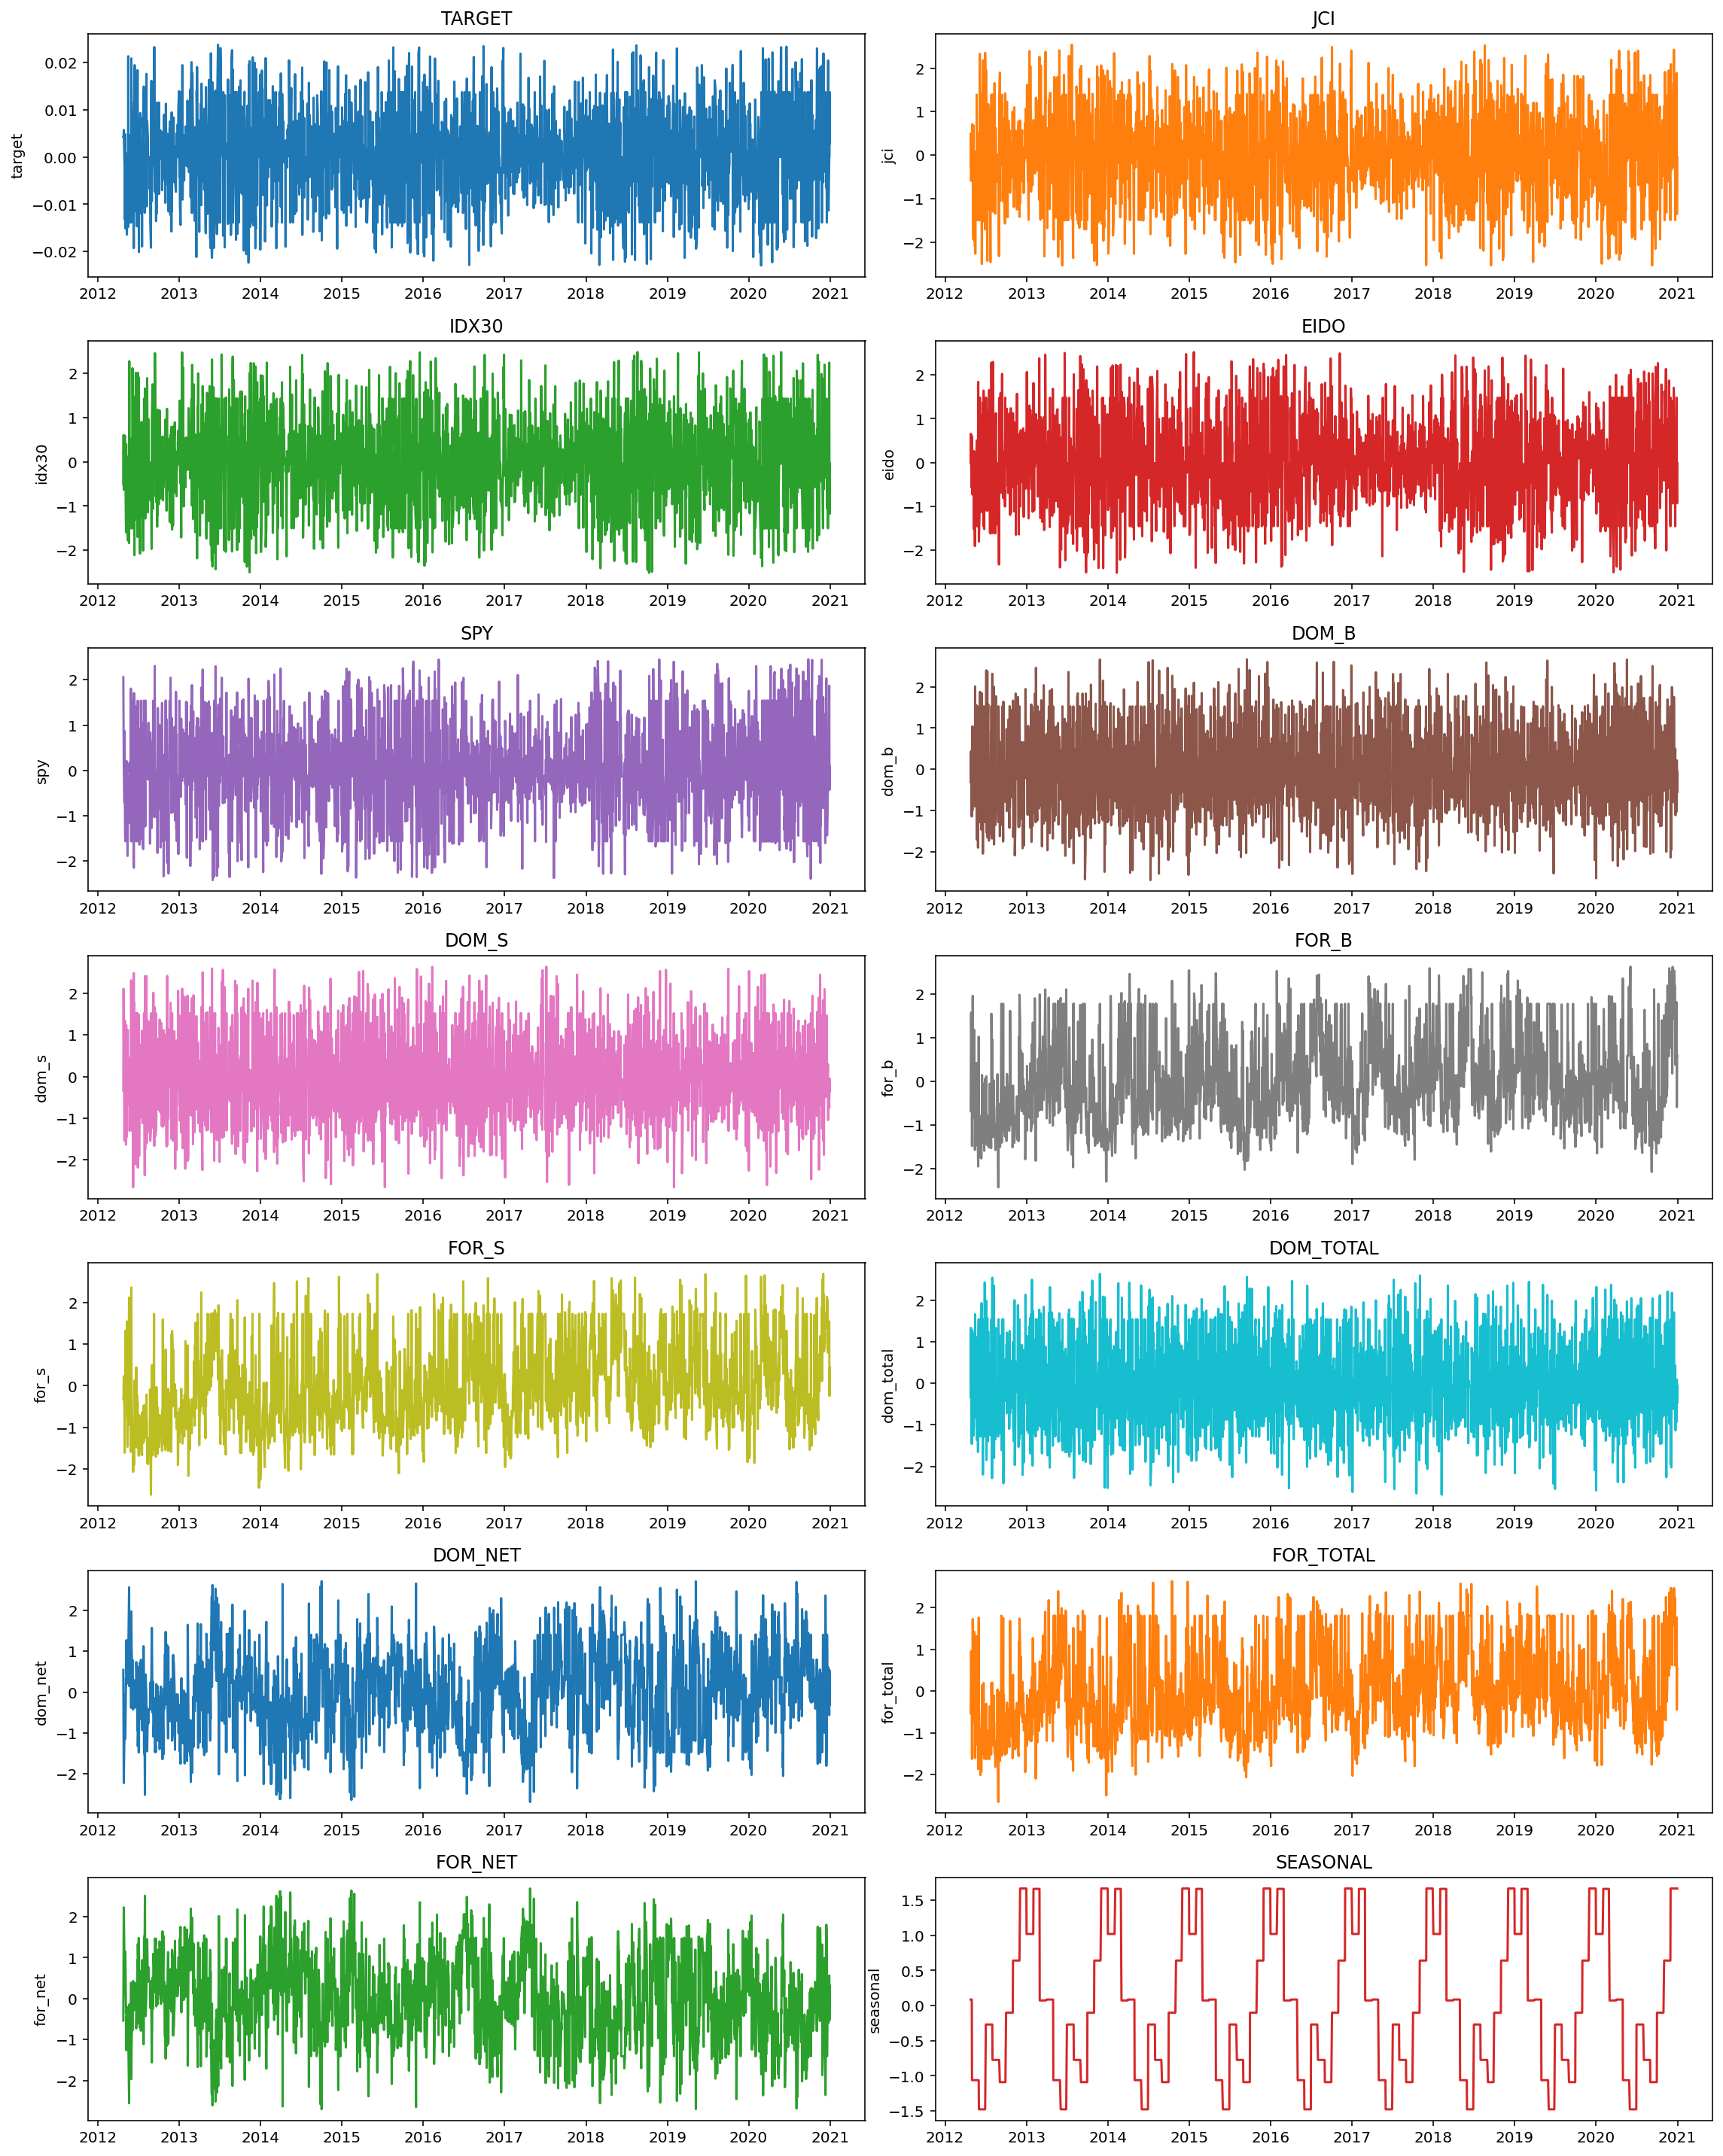

In [10]:
gf.plotting_line_all(dataframe=df_train)